#Домашнее задание № 5. Сингулярный спектральный анализ.

##Загрузим необходимые данные

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

In [ ]:
!pip install arch

In [ ]:
from arch import arch_model

In [ ]:
# загрузим данные
!wget 'https://u.netology.ru/backend/uploads/lms/attachments/files/data/47497/1._Лекция_tsml.zip'

--2025-02-26 08:10:40--  https://u.netology.ru/backend/uploads/lms/attachments/files/data/47497/1._%D0%9B%D0%B5%D0%BA%D1%86%D0%B8%D1%8F_tsml.zip
Resolving u.netology.ru (u.netology.ru)... 213.180.193.247, 2a02:6b8::1da
Connecting to u.netology.ru (u.netology.ru)|213.180.193.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 769056 (751K) [application/x-zip-compressed]
Saving to: ‘1._Лекция_tsml.zip.1’

1._Лекция_tsml.zip. 100%[===================>] 751.03K   819KB/s    in 0.9s    

2025-02-26 08:10:42 (819 KB/s) - ‘1._Лекция_tsml.zip.1’ saved [769056/769056]



In [ ]:
# распакуем
import zipfile

with zipfile.ZipFile('/content/1._Лекция_tsml.zip', 'r') as zip_ref:
    zip_ref.extractall('unpacked_files')

В качестве ряда для анализа выберу monthly_boston_armed_robberies_j. Он мне кажется самым интересным.

In [ ]:
# 2. ежемесячные_бостонские вооруженные_ ограбления_j
monthly_boston_armed_robberies_j = pd.read_csv('/content/unpacked_files/Series/monthly-boston-armed-robberies-j.csv')

In [ ]:
series = monthly_boston_armed_robberies_j['Count']

In [ ]:
# вывод графиков
def chart_2(series_1, series_2=None, title=None):
    plt.figure(figsize=(14, 7))
    plt.plot(series_1, label='Временной ряд')
    if series_2 is not None:
        plt.plot(series_2, label=title)
    plt.title('Визуальное сравнение полученного временного ряда')
    plt.xlabel('Время')
    plt.ylabel('Величина')
    plt.grid(False)
    plt.legend()
    plt.show()

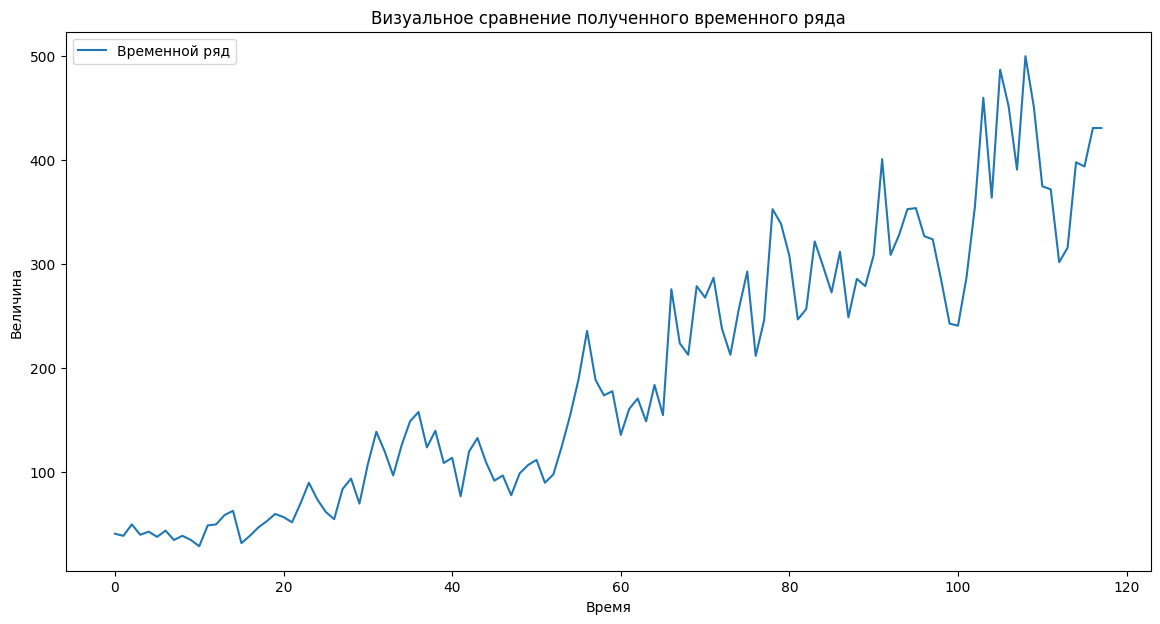

In [ ]:
# еще раз на него посмотрим
chart_2(series)

Скопирую функции для анализа ряда

In [ ]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [ ]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()
    return

##Модель GARCH

In [ ]:
# загрузим библиотеки
from statsmodels.tsa.arima.model import ARIMA
import itertools

In [ ]:
# подбор лучших параметров для модели ARIMA
def _get_best_model(TS):
    # отключаем сообщения об ошибках
    import warnings
    warnings.filterwarnings('ignore')

    # для поиска наилучших параметров воспользуемся поиском по сетке
    p = range(0,5)
    d = q = range(0,3)
    pdq = list(itertools.product(p, d, q))
    print(f'Всего рассмотрим {len(pdq)} вариантов')
    best_pdq = (0,0,0)

    # для поиска лучшей модели воспользуемся информационным критерием aic.
    # AIC — Akaike Information Criterion). AIC оценивает, насколько хорошо модель подходит под данные.
    # чем меньше AIC – тем точнее модель
    best_aic = np.inf

    for params in pdq:
        model_test = ARIMA(series, order=params)
        result_test = model_test.fit()

        if result_test.aic < best_aic:
            best_pdq = params
            best_aic = result_test.aic
            best_mod = result_test

    return best_pdq, best_aic, best_mod

In [ ]:
# получим лучшие значения для модели ARIMA
best_pdq, best_aic, best_mod = _get_best_model(series)

Всего рассмотрим 45 вариантов


Results of Dickey-Fuller Test:
Test Statistic                -7.020377e+00
p-value                        6.566831e-10
#Lags Used                     9.000000e+00
Number of Observations Used    1.080000e+02
Critical Value (1%)           -3.492401e+00
Critical Value (5%)           -2.888697e+00
Critical Value (10%)          -2.581255e+00
dtype: float64


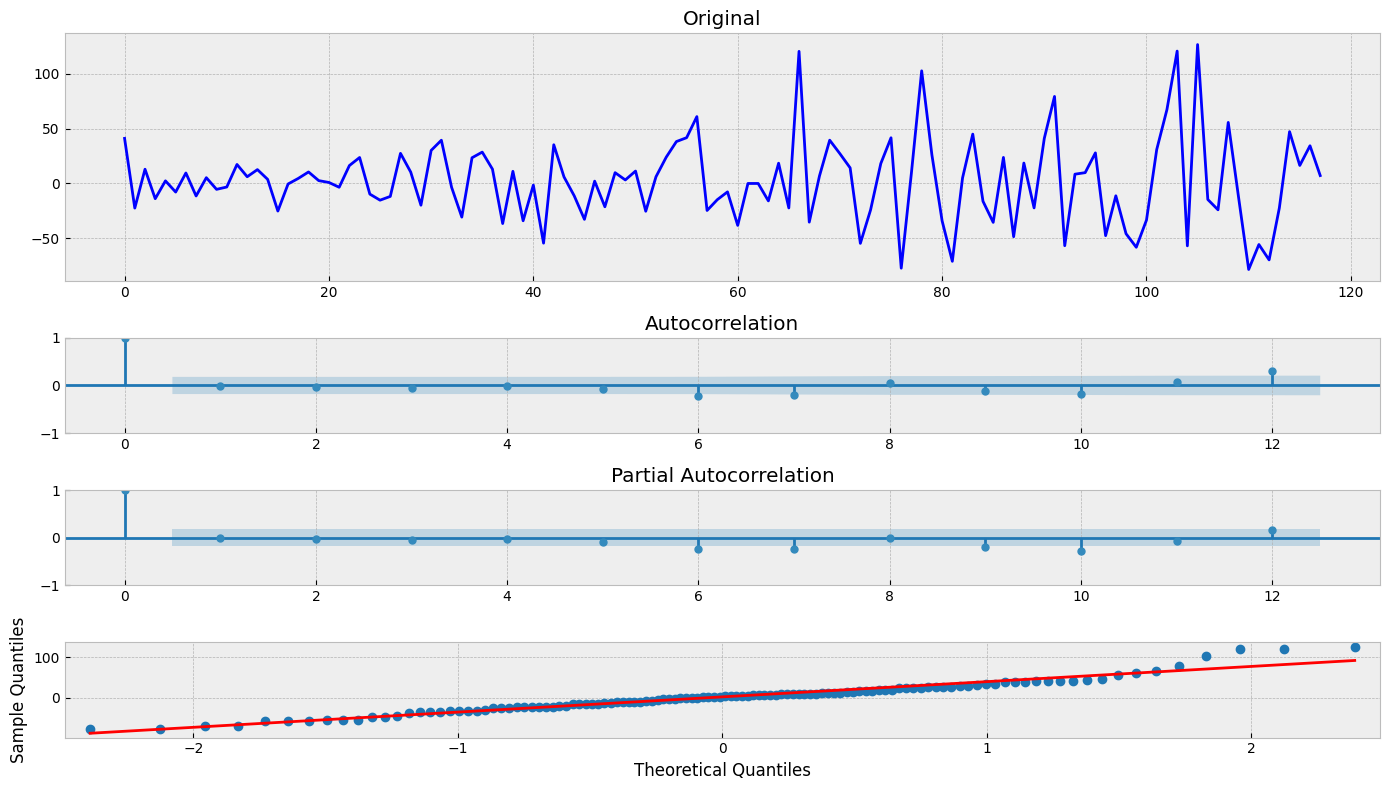

In [ ]:
# посмотрим на ARIMA
tsplot(best_mod.resid, lags=12)

In [ ]:
# подставим полученные значения в GARCH
p_ = best_pdq[0]
o_ = best_pdq[1]
q_ = best_pdq[2]

am = arch_model(best_mod.resid, vol='GARCH', p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -578.670
Distribution:      Standardized Student's t   AIC:                           1177.34
Method:                  Maximum Likelihood   BIC:                           1205.05
                                              No. Observations:                  118
Date:                      Wed, Feb 26 2025   Df Residuals:                      117
Time:                              08:12:32   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             2

Results of Dickey-Fuller Test:
Test Statistic                -7.020377e+00
p-value                        6.566831e-10
#Lags Used                     9.000000e+00
Number of Observations Used    1.080000e+02
Critical Value (1%)           -3.492401e+00
Critical Value (5%)           -2.888697e+00
Critical Value (10%)          -2.581255e+00
dtype: float64


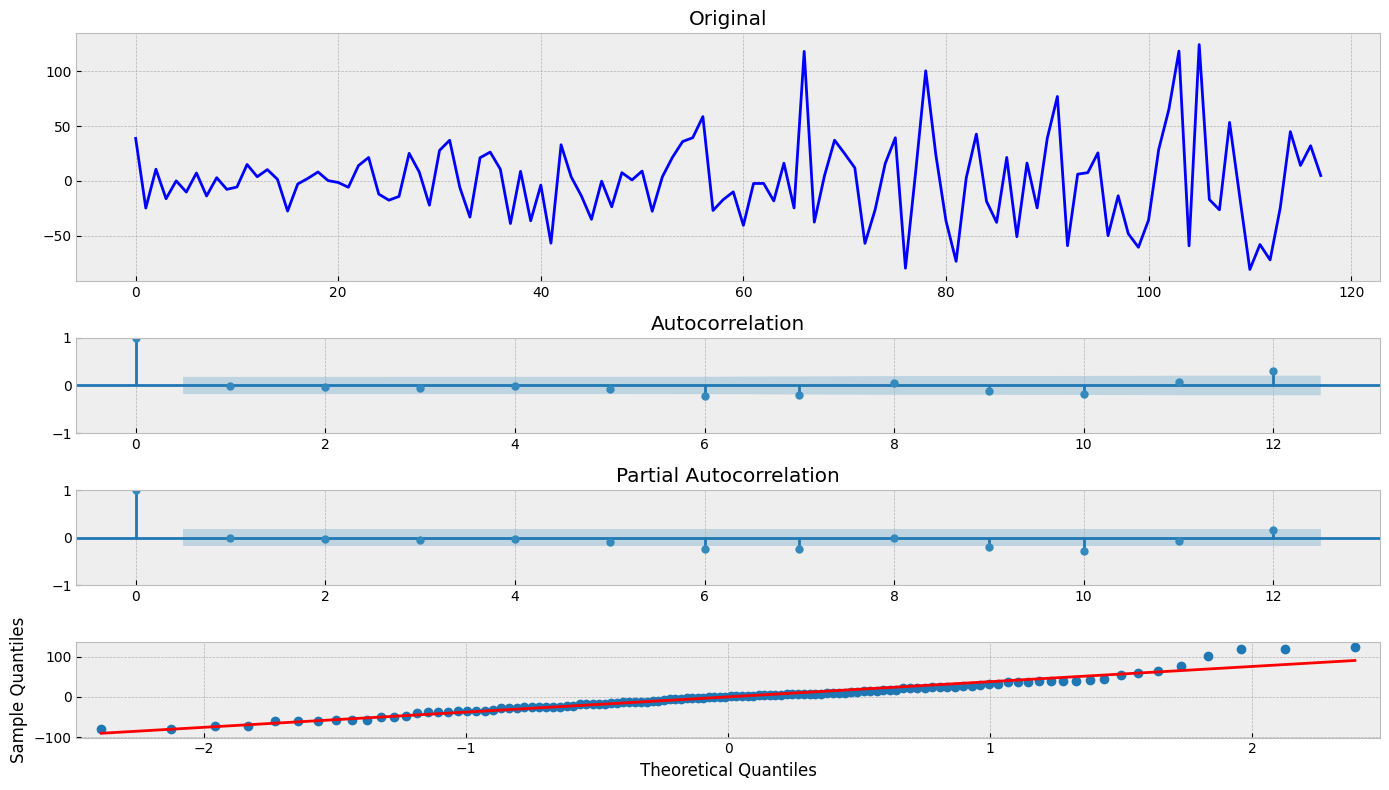

In [ ]:
# посмотрим на результат
tsplot(res.resid, lags=12)

Results of Dickey-Fuller Test:
Test Statistic                  -5.288916
p-value                          0.000006
#Lags Used                       1.000000
Number of Observations Used    116.000000
Critical Value (1%)             -3.488022
Critical Value (5%)             -2.886797
Critical Value (10%)            -2.580241
dtype: float64


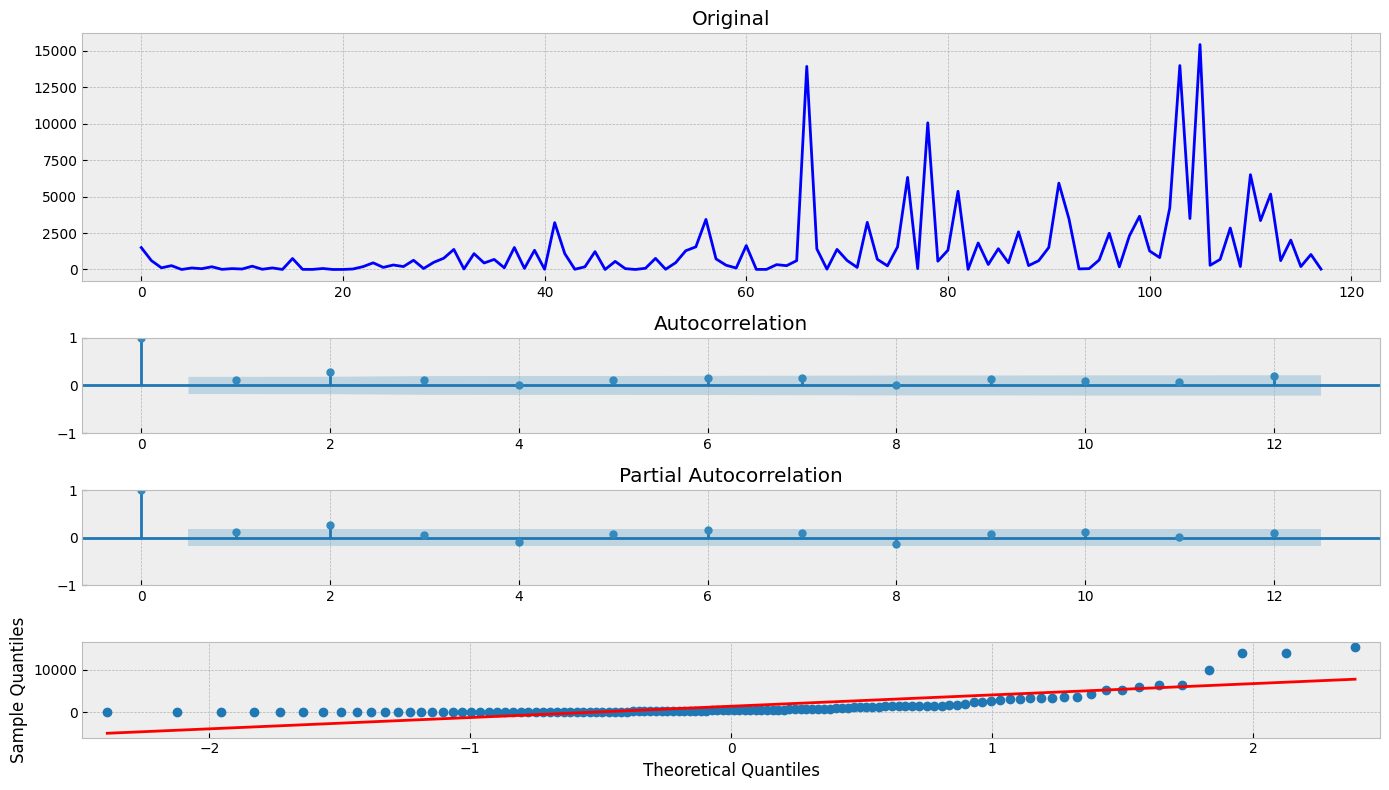

In [ ]:
# и вот так
tsplot(res.resid**2, lags=12)

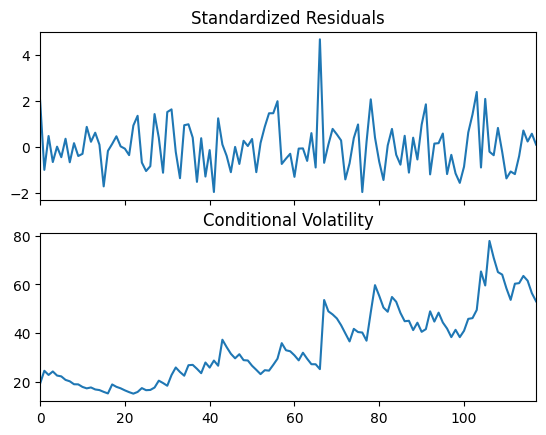

In [ ]:
# посмотреть можно еще так
res.plot()
plt.show()